# Using the Berkeley [Loadshape](https://bitbucket.org/berkeleylab/eetd-loadshape) library for regression features and to fill gaps

- Clayton Miller (miller.clayton@gmail.com)
- http://datadrivenbuilding.org/

We will use the techniques in LoadShape to:
- Fill gaps in the data
- Create a set of regression features for characterization

In [83]:
from loadshape import Loadshape

In [1187]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
from pylab import *
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [85]:
sns.set_style("whitegrid")

In [86]:
%matplotlib inline

First, get the raw data:

In [87]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [1025]:
temp = pd.read_csv(os.path.join(repos_path,"data/raw/temp_open_utc.csv"), index_col="timestamp", parse_dates=True)

In [1026]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

## First, let's just test one building to understand the library's output and how it works

In [997]:
testbuilding = "UnivLab_Alfonso"

In [998]:
test_timezone = meta.T[testbuilding].timezone
test_start = meta.T[testbuilding].datastart
test_end = meta.T[testbuilding].dataend
test_building_data = pd.DataFrame(temp[testbuilding].tz_localize('utc').tz_convert(test_timezone).truncate(before=test_start,after=test_end))

In [1007]:
test_start#.to_datetime()

Timestamp('2015-01-01 00:00:00')

In [1008]:
test_end

Timestamp('2015-12-31 23:00:00')

In [1009]:
test_timezone

'America/Phoenix'

In [1010]:
test_building_data.tail()

,UnivLab_Alfonso
timestamp,
2015-12-31 19:00:00-07:00,NaN
2015-12-31 20:00:00-07:00,NaN
2015-12-31 21:00:00-07:00,NaN
2015-12-31 22:00:00-07:00,NaN
2015-12-31 23:00:00-07:00,NaN


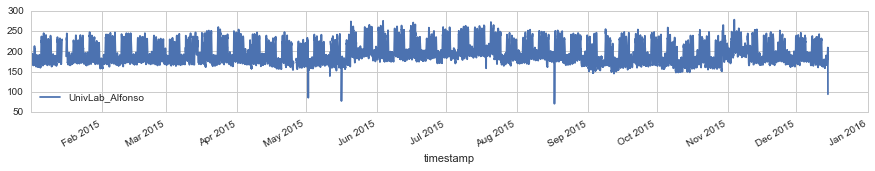

In [1011]:
test_building_data.plot(figsize=(15,2));

In [800]:
weatherfilename = meta.T[testbuilding].newweatherfilename

In [801]:
weatherfilename

'weather0.csv'

In [802]:
test_weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
test_weather = test_weather.tz_localize(test_timezone, ambiguous = 'infer')

In [803]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8999 entries, 2015-01-01 00:51:00-07:00 to 2015-12-31 23:51:00-07:00
Data columns (total 15 columns):
TimeMST                  8999 non-null object
TemperatureC             8990 non-null float64
Dew PointC               8990 non-null float64
Humidity                 8990 non-null float64
Sea Level PressurehPa    8999 non-null float64
VisibilityKm             8988 non-null float64
Wind Direction           8999 non-null object
Wind SpeedKm/h           8980 non-null object
Gust SpeedKm/h           8999 non-null object
Precipitationmm          443 non-null float64
Events                   330 non-null object
Conditions               8999 non-null object
WindDirDegrees           8999 non-null int64
DateUTC<br />            8999 non-null object
timestamp.1              8999 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 1.1+ MB


In [804]:
outdoor_temp = pd.DataFrame(test_weather[[col for col in test_weather.columns if 'Temperature' in col]]).resample("H").mean()

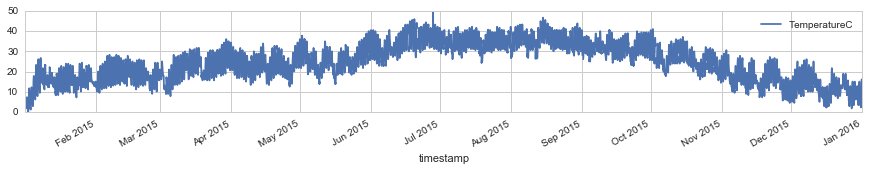

In [805]:
outdoor_temp.plot(figsize=(15,2));

In [806]:
def create_loadshapeinput_format(df, colname):
    inputdata = []
    for x, y in zip(df.index.format('%Y-%m-%d %H:%M:%S.%f')[1:], df[colname]):
        inputdata.append((x,y))
    return inputdata

In [807]:
timezone = meta.T[testbuilding].timezone

In [808]:
actual_consumption = create_loadshapeinput_format(test_building_data.tz_localize(None), testbuilding)
actual_weather = create_loadshapeinput_format(outdoor_temp.tz_localize(None), "TemperatureC")

In [809]:
#actual_weather

In [810]:
timezone

'America/Phoenix'

In [811]:
loadshapemodel = Loadshape(actual_consumption, actual_weather, timezone=timezone, temp_units="C")

In [812]:
predicted = loadshapemodel.baseline().data()

In [813]:
test_building_predicted = pd.DataFrame(predicted)
test_building_predicted.index = pd.to_datetime(test_building_predicted[0], unit="s")
test_building_predicted = pd.DataFrame({testbuilding+'_predicted':test_building_predicted[1].tz_localize('utc').tz_convert(timezone)}) #.tz_localize(timezone, ambiguous='infer')

In [814]:
test_building_predicted.resample('H').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8345 entries, 2015-01-01 00:00:00-07:00 to 2015-12-14 16:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivLab_Alfonso_predicted    8345 non-null float64
dtypes: float64(1)
memory usage: 130.4 KB


In [815]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivLab_Alfonso    8261 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [816]:
test_building_predicted = test_building_predicted.resample("H").mean()

In [817]:
combined = pd.merge(test_building_predicted, test_building_data, right_index=True, left_index=True)
#combined = combined.tz_convert(timezone)

In [818]:
#combined.columns = ["Predicted","Actual"]
combined.tail()

,UnivLab_Alfonso_predicted,UnivLab_Alfonso
2015-12-14 19:00:00+00:00,216.0050,NaN
2015-12-14 20:00:00+00:00,220.2375,NaN
2015-12-14 21:00:00+00:00,220.3525,NaN
2015-12-14 22:00:00+00:00,220.0775,NaN
2015-12-14 23:00:00+00:00,219.8800,67.23


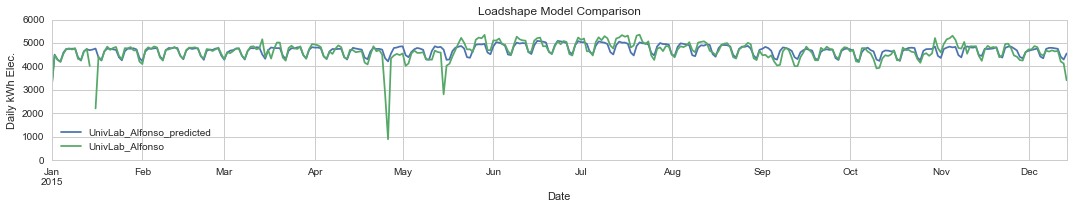

In [819]:
combined.resample('D').sum().plot(figsize=(15,3))
plt.xlabel("Date")
plt.ylabel("Daily kWh Elec.")
plt.title("Loadshape Model Comparison")
plt.tight_layout()
plt.savefig(os.path.join(repos_path,"reports/figures/loadshape/predictedvsactual_annual.png"));

One can see that in the third week of May, there is a dip in the actual vs. predicted. This is due to missing data. If we zoom in:

In [822]:
zoomdatestart = '2015-01-01'
zoomdateend = '2015-03-01'

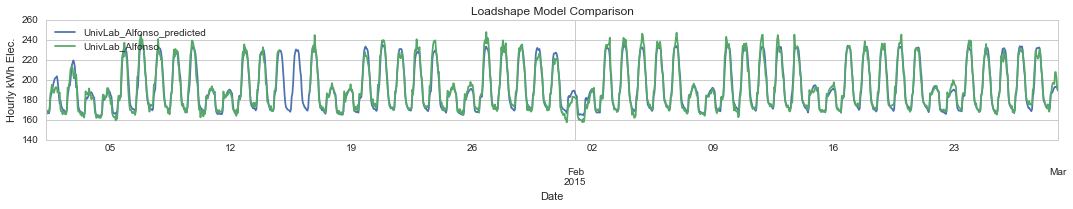

In [823]:
combined.truncate(before=zoomdatestart,after=zoomdateend).plot(figsize=(15,3))
plt.xlabel("Date")
plt.ylabel("Hourly kWh Elec.")
plt.title("Loadshape Model Comparison")
plt.tight_layout()
plt.savefig(os.path.join(repos_path,"reports/figures/loadshape/predictedvsactual_zoomin.png"));

In [824]:
test_building_predicted.resample('H').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8345 entries, 2015-01-01 00:00:00-07:00 to 2015-12-14 16:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivLab_Alfonso_predicted    8345 non-null float64
dtypes: float64(1)
memory usage: 130.4 KB


In [825]:
errors = pd.DataFrame({testbuilding:loadshapemodel.error_stats})

In [826]:
errors

,UnivLab_Alfonso
corr_hour,0.930
corr_interval,0.930
corr_interval_daytime,0.880
mape_hour,3.446
mape_interval,3.446
mape_interval_daytime,3.658
rmse_hour,9.527
rmse_interval,9.527
rmse_interval_daytime,10.749


In [827]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivLab_Alfonso    8261 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [828]:
test_building_data_predicted = test_building_predicted.resample("H").mean()

In [829]:
test_building_data_predicted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8345 entries, 2015-01-01 00:00:00-07:00 to 2015-12-14 16:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivLab_Alfonso_predicted    8345 non-null float64
dtypes: float64(1)
memory usage: 130.4 KB


As you can see, the test_building_actual has 8690 points and the predicted has 8760. We will use the pandas ".update" function to overlay the predicted onto the actual and replace ONLY the NaN values.

In [830]:
test_building_data_predicted.columns = [testbuilding]

In [831]:
test_building_data.update(test_building_data_predicted, overwrite=False)

In [832]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivLab_Alfonso    8345 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [833]:
test_building_data_predicted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8345 entries, 2015-01-01 00:00:00-07:00 to 2015-12-14 16:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivLab_Alfonso    8345 non-null float64
dtypes: float64(1)
memory usage: 130.4 KB


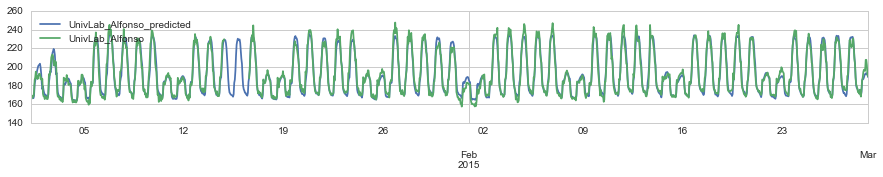

In [834]:
combined.truncate(before=zoomdatestart,after=zoomdateend).plot(figsize=(15,2));

You can see the gap above and how its filled below

In [835]:
#temp_gapsfilled[testbuilding].truncate(before=zoomdatestart,after=zoomdateend).plot(figsize=(15,2));

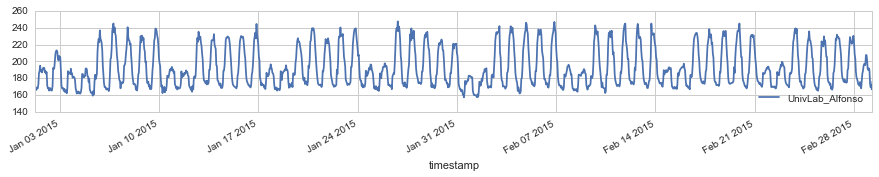

In [836]:
test_building_data.truncate(before=zoomdatestart,after=zoomdateend).plot(figsize=(15,2));

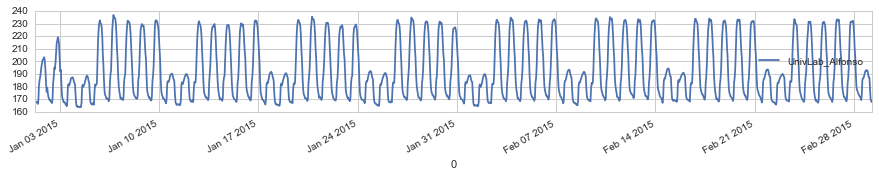

In [837]:
test_building_data_predicted.truncate(before=zoomdatestart,after=zoomdateend).plot(figsize=(15,2));

In [838]:
test_building_data_predicted.truncate(after="2015-11-02").tail()

,UnivLab_Alfonso
0,
2015-11-01 20:00:00-07:00,180.7500
2015-11-01 21:00:00-07:00,174.8950
2015-11-01 22:00:00-07:00,175.1025
2015-11-01 23:00:00-07:00,173.7150
2015-11-02 00:00:00-07:00,175.4000


Now, test_building_data is filled in with the model data

In [839]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivLab_Alfonso    8345 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


## Get the residuals

UnivLab_Alfonso    242.61
dtype: float64

In [857]:
residuals = (test_building_data - test_building_data_predicted) / test_building_data.dropna().quantile(q=0.95)

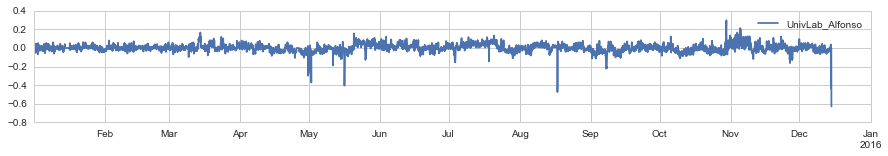

In [858]:
residuals.plot(figsize=(15,2));

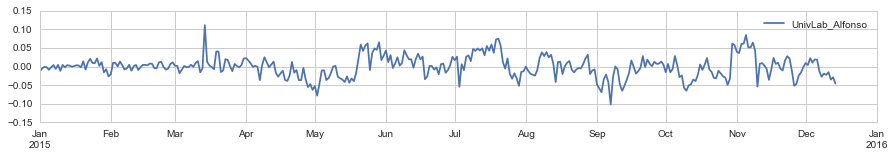

In [859]:
residuals.resample('D').mean().plot(figsize=(15,2));

# Loop through all buildings and run load shape model

In [577]:
def runloadshapemodel(meta, temp, building):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = pd.DataFrame(temp[building].tz_localize('utc').tz_convert(timezone).truncate(before=start,after=end))
    
    weatherfilename = meta.T[building].newweatherfilename
    
    weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
    weather = weather.tz_localize(timezone, ambiguous = 'infer')
    outdoor_temp = pd.DataFrame(weather[[col for col in test_weather.columns if 'Temperature' in col]]).resample("H").mean()
    
    building_data_actual = create_loadshapeinput_format(building_data.tz_localize(None), building)
    actual_weather = create_loadshapeinput_format(outdoor_temp.tz_localize(None), "TemperatureC")
    
    loadshapemodel = Loadshape(building_data_actual, actual_weather, timezone=timezone, temp_units="C")
    
    building_data_predicted = loadshapemodel.baseline().data()
    
    building_data_predicted = pd.DataFrame(building_data_predicted)
    building_data_predicted.index = pd.to_datetime(building_data_predicted[0], unit="s")
    building_data_predicted = pd.DataFrame({building+'_predicted':building_data_predicted.tz_localize('UTC').tz_convert(timezone)[1]})
    
    errors = pd.DataFrame({building:loadshapemodel.error_stats})
    
    building_data_predicted = building_data_predicted.resample("H").mean()
    building_data_predicted.columns = [building]
    
    building_data.update(building_data_predicted, overwrite=False)
    
    residuals = building_data - building_data_predicted
    
    return errors, building_data, building_data_predicted, residuals

## Test on one building

In [622]:
#temp["UnivClass_Clifford"].dropna()

In [608]:
errors, building_data, building_data_predicted, residuals = runloadshapemodel(meta, temp, "UnivClass_Clifford")

In [609]:
errors

,UnivClass_Clifford
corr_hour,0.880
corr_interval,0.880
corr_interval_daytime,0.850
mape_hour,4.603
mape_interval,4.603
mape_interval_daytime,4.527
rmse_hour,0.086
rmse_interval,0.086
rmse_interval_daytime,0.093


In [616]:
building_data_predicted.head()

,UnivClass_Clifford
0,
2015-01-02 00:00:00-05:00,1.3500
2015-01-02 01:00:00-05:00,1.3575
2015-01-02 02:00:00-05:00,1.3450
2015-01-02 03:00:00-05:00,1.3550
2015-01-02 04:00:00-05:00,1.3900


In [617]:
building_data.update(building_data_predicted, overwrite=False)

In [619]:
building_data_predicted

,UnivClass_Clifford
0,
2015-01-02 00:00:00-05:00,1.3500
2015-01-02 01:00:00-05:00,1.3575
2015-01-02 02:00:00-05:00,1.3450
2015-01-02 03:00:00-05:00,1.3550
2015-01-02 04:00:00-05:00,1.3900
2015-01-02 05:00:00-05:00,1.3925
2015-01-02 06:00:00-05:00,1.3900
2015-01-02 07:00:00-05:00,1.4125
2015-01-02 08:00:00-05:00,1.4650


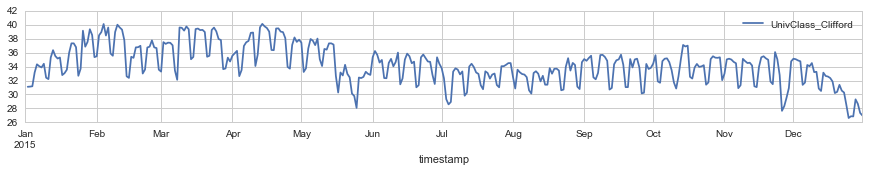

In [611]:
building_data.resample('D').sum().plot(figsize=(15,2));

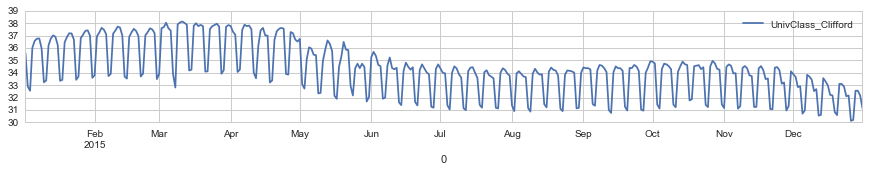

In [612]:
#building_data.tz_convert("UTC").resample('D',how='sum')#.plot(figsize=(15,2))
building_data_predicted.resample('D').sum().plot(figsize=(15,2));

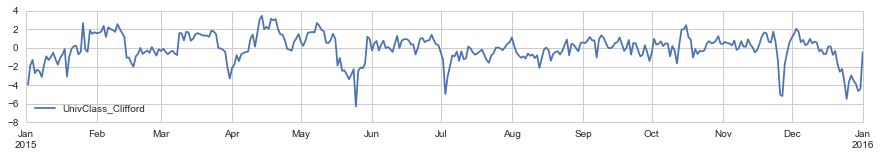

In [613]:
residuals.resample('D').sum().plot(figsize=(15,2));

# Implement on all buildings

In [598]:
buildinglist = list(meta.index)

In [860]:
#buildinglist[100:110]

### The following loop takes around 8 hours to run -- this section has been commented out because when I rerun this notebook, I don't want to rerun the calculations. The output is documented in the markdown cell below for reference. To use the output data, one can reload the output files from the `/data/interim folder/temp_nogaps_utc.csv`

It is noticed that several of the runs have R errors -- spot checking the outputs of these buildings shows that they are as expected. Will have to dig into the source of the R errors. One buildings `Office_Gemma` straight up failed -- Upon further investigation, it looks like its weather file was at fault. Below, we rerun Gemma with the weather file updated in the `meta_open.csv` file.

In [862]:
# temp_gapsfilled = pd.DataFrame()
# temp_loadshape_predicted = pd.DataFrame()
# temp_residuals = pd.DataFrame()
# features_loadshape_errors = pd.DataFrame()

# for building in buildinglist:
#     start_time = timeit.default_timer()
#     try:
#         errors, building_data, building_data_predicted, residuals = runloadshapemodel(meta, temp, building)
#     except:
#         print "Couldn't model: "+building
        
#     temp_gapsfilled = pd.merge(temp_gapsfilled, building_data.tz_convert('utc'), right_index=True, left_index=True, how='outer')
#     temp_loadshape_predicted = pd.merge(temp_loadshape_predicted, building_data_predicted.tz_convert('utc'), right_index=True, left_index=True, how='outer')
#     temp_residuals = pd.merge(temp_residuals, residuals.tz_convert('utc'), right_index=True, left_index=True, how='outer')
#     features_loadshape_errors = pd.merge(features_loadshape_errors, errors, right_index=True, left_index=True, how='outer')
    
#     print "Calculated: "+building+" in "+str(timeit.default_timer() - start_time)+" seconds"


```
Calculated: PrimClass_Everett in 50.9786071777 seconds
Calculated: UnivClass_Clifford in 48.7507898808 seconds
Calculated: Office_Elizabeth in 50.9081821442 seconds
Calculated: Office_Ellie in 50.7341561317 seconds
Calculated: PrimClass_Elisabeth in 51.2681188583 seconds
Calculated: Office_Cristina in 50.2824809551 seconds
Calculated: PrimClass_Jolie in 50.0086910725 seconds
Calculated: PrimClass_Jaylin in 50.3263890743 seconds
Calculated: Office_Jesus in 50.1731030941 seconds
Calculated: PrimClass_Esmeralda in 51.5968029499 seconds
Calculated: PrimClass_Eoghan in 51.7294299603 seconds
Calculated: PrimClass_Edwin in 51.0874991417 seconds
Calculated: PrimClass_Eli in 51.0730688572 seconds
Calculated: PrimClass_Ethel in 50.7655220032 seconds
Calculated: PrimClass_Ernesto in 50.7820191383 seconds
Calculated: PrimClass_Emanuela in 50.6203939915 seconds
Calculated: PrimClass_Emilio in 50.5619368553 seconds
Calculated: PrimClass_Eleanor in 50.7991671562 seconds
Calculated: PrimClass_Ezekiel in 50.4407799244 seconds
Calculated: PrimClass_Elliott in 51.5564219952 seconds
Calculated: PrimClass_Ellen in 51.0026400089 seconds
Calculated: PrimClass_Evie in 51.058257103 seconds
Calculated: PrimClass_Elijah in 51.1028778553 seconds
Calculated: PrimClass_Ezra in 51.7987940311 seconds
Calculated: PrimClass_Edmund in 51.2817161083 seconds
Calculated: PrimClass_Eva in 51.592952013 seconds
Calculated: Office_Erik in 51.4144220352 seconds
Calculated: PrimClass_Ebony in 51.1741249561 seconds
Calculated: PrimClass_Ethan in 50.7490818501 seconds
Calculated: PrimClass_Elmer in 51.5720560551 seconds
Calculated: PrimClass_Ervin in 51.1501369476 seconds
Calculated: PrimClass_Uma in 51.1862170696 seconds
Calculated: UnivClass_Tamra in 52.5973918438 seconds
Calculated: PrimClass_Ernest in 51.6126661301 seconds
Calculated: PrimClass_Emily in 51.1055459976 seconds
Calculated: Office_Evelyn in 50.8608901501 seconds
Calculated: PrimClass_Jayla in 50.0038108826 seconds
Calculated: Office_Emer in 50.4408931732 seconds
Calculated: PrimClass_Janiya in 49.5603370667 seconds
Calculated: PrimClass_Umar in 49.3659210205 seconds
Calculated: Office_Elena in 50.6985039711 seconds
Calculated: PrimClass_Janice in 49.5105001926 seconds
Calculated: Office_Jett in 50.8407440186 seconds
Calculated: UnivDorm_Una in 50.278247118 seconds
Calculated: UnivLab_Paul in 50.7749769688 seconds
Calculated: Office_Jerry in 50.5691971779 seconds
Calculated: Office_Eileen in 48.1240119934 seconds
Calculated: PrimClass_Uriah in 49.9068820477 seconds
Calculated: PrimClass_Ulysses in 50.5512740612 seconds
Calculated: Office_Lesa in 51.8346710205 seconds
Calculated: UnivDorm_Claudia in 51.3888399601 seconds
Calculated: Office_Emerald in 52.0722620487 seconds
Calculated: Office_Ellis in 51.974091053 seconds
Calculated: UnivClass_Tammy in 51.7684831619 seconds
Calculated: PrimClass_Jaden in 52.0003521442 seconds
Calculated: Office_Elliot in 53.0151679516 seconds
Calculated: PrimClass_Jermaine in 52.2332379818 seconds
Calculated: PrimClass_Josephine in 51.7562551498 seconds
Calculated: Office_Eddie in 52.4291169643 seconds
Calculated: Office_Jackie in 49.2536058426 seconds
Calculated: UnivDorm_Carla in 52.6590890884 seconds
Calculated: UnivClass_Camden in 51.2266788483 seconds
Calculated: PrimClass_Javier in 50.4104888439 seconds
Calculated: PrimClass_Jeanette in 49.4431080818 seconds
Calculated: PrimClass_Julius in 50.2517340183 seconds
Calculated: PrimClass_Jaylinn in 50.5054838657 seconds
Calculated: PrimClass_Johanna in 51.0793018341 seconds
Calculated: PrimClass_Jodie in 51.0298480988 seconds
Calculated: PrimClass_Johnathan in 50.8208801746 seconds
Calculated: PrimClass_Janis in 50.8521208763 seconds
Calculated: PrimClass_Jamal in 49.4484000206 seconds
Calculated: PrimClass_Jose in 50.0996589661 seconds
Calculated: PrimClass_Julianna in 49.6515069008 seconds
Calculated: PrimClass_Jasmine in 52.6462099552 seconds
Calculated: PrimClass_Jazmine in 52.4557249546 seconds
Calculated: PrimClass_Justin in 52.6718270779 seconds
Calculated: Office_Marla in 53.568721056 seconds
Calculated: PrimClass_Jody in 50.9424901009 seconds
Calculated: PrimClass_Julianne in 50.2524719238 seconds
Calculated: PrimClass_Justice in 51.6709430218 seconds
Calculated: UnivClass_Craig in 52.0742740631 seconds
Calculated: PrimClass_Jean in 50.1881530285 seconds
Calculated: PrimClass_Jenna in 51.7073528767 seconds
Calculated: PrimClass_Judith in 52.5927431583 seconds
Calculated: PrimClass_Jessie in 51.7378468513 seconds
Calculated: PrimClass_Joselyn in 51.8488810062 seconds
Calculated: UnivLab_Bethany in 52.2337989807 seconds
Calculated: PrimClass_Judy in 51.0657470226 seconds
Calculated: PrimClass_Jarrett in 51.379981041 seconds
Calculated: PrimClass_Jeannine in 50.4541270733 seconds
Calculated: PrimClass_Jeff in 51.0358090401 seconds
Calculated: PrimClass_Julian in 52.3547239304 seconds
Calculated: PrimClass_Jeanine in 53.0300049782 seconds
Calculated: UnivClass_Jadon in 51.7520830631 seconds
Calculated: Office_Maryann in 52.3419811726 seconds
Calculated: UnivClass_Boyd in 52.6429691315 seconds
Calculated: PrimClass_Jerome in 52.5023140907 seconds
Calculated: PrimClass_Jacqueline in 52.1206729412 seconds
Calculated: PrimClass_Jill in 50.7144579887 seconds
Calculated: PrimClass_Jim in 51.8804531097 seconds
Calculated: Office_Myron in 52.3047468662 seconds
Calculated: PrimClass_Janet in 52.0205430984 seconds
Calculated: PrimClass_Janie in 51.9564011097 seconds
Calculated: PrimClass_Jensen in 52.570376873 seconds
Calculated: PrimClass_Jeffrey in 53.0319890976 seconds
Calculated: Office_Conrad in 50.8575470448 seconds
Calculated: UnivDorm_Prince in 52.1155450344 seconds
Calculated: PrimClass_Jennifer in 51.5938429832 seconds
Calculated: UnivClass_Therese in 52.7130110264 seconds
Calculated: PrimClass_Jesse in 52.6849031448 seconds
Calculated: Office_Mick in 53.8832988739 seconds
Calculated: PrimClass_Jaxson in 51.3781130314 seconds
Calculated: PrimClass_Jimmie in 49.8124828339 seconds
Calculated: Office_Jayden in 52.063628912 seconds
Calculated: UnivDorm_Chelsey in 52.1487238407 seconds
Calculated: PrimClass_Jayda in 52.967168808 seconds
Calculated: UnivDorm_Christopher in 54.8322401047 seconds
Calculated: PrimClass_Jocelyn in 52.8799901009 seconds
Calculated: PrimClass_Jeffery in 52.6515479088 seconds
Calculated: UnivDorm_Cheyenne in 52.0755081177 seconds
Calculated: UnivDorm_Patti in 52.2313539982 seconds
Calculated: PrimClass_Jayson in 51.4654641151 seconds
Calculated: UnivLab_Crystal in 52.3142778873 seconds
Calculated: UnivDorm_Jeannette in 50.6140038967 seconds
Calculated: Office_Moises in 52.2114930153 seconds
Calculated: PrimClass_Jennie in 52.0356729031 seconds
Calculated: PrimClass_Jonathon in 53.3252568245 seconds
Calculated: UnivDorm_Christi in 54.0915770531 seconds
Calculated: PrimClass_Jaqueline in 50.9335639477 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivClass_Amari in 52.8060929775 seconds
Calculated: Office_Tod in 51.9442420006 seconds
Calculated: PrimClass_Jeremy in 52.1416039467 seconds
Calculated: PrimClass_Josue in 52.590239048 seconds
Calculated: UnivDorm_Marlene in 52.0046269894 seconds
Calculated: UnivClass_Teri in 52.8611578941 seconds
Calculated: PrimClass_Julio in 51.4725470543 seconds
Calculated: UnivDorm_Cheri in 52.8738219738 seconds
Calculated: UnivDorm_Lorraine in 51.0553030968 seconds
Calculated: PrimClass_Jacquelyn in 51.7252869606 seconds
Calculated: PrimClass_Juanita in 52.8904168606 seconds
Calculated: PrimClass_Joel in 50.863232851 seconds
Calculated: Office_Marcus in 50.4385550022 seconds
Calculated: UnivClass_Candy in 51.0077700615 seconds
Calculated: PrimClass_Joey in 50.7631931305 seconds
Calculated: UnivDorm_Celeste in 52.4259438515 seconds
Calculated: UnivClass_Shawna in 51.7123310566 seconds
Calculated: PrimClass_Joanna in 52.0795509815 seconds
Calculated: UnivClass_Ariana in 52.1105668545 seconds
Calculated: PrimClass_Jediah in 49.8035330772 seconds
Calculated: Office_Bobbi in 52.356222868 seconds
Calculated: Office_Georgia in 50.0699470043 seconds
Calculated: PrimClass_Janelle in 50.2443599701 seconds
Calculated: Office_Skyler in 52.0394179821 seconds
Calculated: Office_Marc in 53.0601890087 seconds
Calculated: Office_Mary in 52.7853701115 seconds
Calculated: UnivDorm_Payton in 54.7386610508 seconds
Calculated: Office_Ayesha in 52.7792282104 seconds
Calculated: PrimClass_Jane in 53.5618329048 seconds
Calculated: PrimClass_Jon in 51.4613339901 seconds
Calculated: UnivDorm_Patty in 52.8948659897 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Adan in 54.5931520462 seconds
Calculated: Office_Monty in 51.8954520226 seconds
Calculated: UnivLab_Clint in 51.5589590073 seconds
Calculated: PrimClass_Jake in 51.6331450939 seconds
Calculated: Office_Joan in 48.5430278778 seconds
Calculated: UnivLab_Cesar in 49.0225458145 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Cian in 48.4347250462 seconds
Calculated: PrimClass_Johnnie in 47.5448269844 seconds
Calculated: Office_Marlon in 48.2691628933 seconds
Calculated: UnivDorm_Curtis in 49.0456109047 seconds
Calculated: UnivDorm_Leonard in 48.2472119331 seconds
Calculated: Office_Javon in 47.8468458652 seconds
Calculated: UnivClass_Pete in 48.372262001 seconds
Calculated: PrimClass_Johnathon in 47.4898350239 seconds
Calculated: Office_Jeanne in 47.863902092 seconds
Calculated: PrimClass_Jamie in 48.6106488705 seconds
Calculated: Office_Pamela in 48.4855978489 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: Office_Allyson in 48.0961871147 seconds
Calculated: PrimClass_Jacob in 47.0357530117 seconds
Calculated: Office_Amelie in 48.022439003 seconds
Calculated: UnivDorm_Patrice in 48.9877941608 seconds
Calculated: UnivClass_Alexander in 50.7736480236 seconds
Calculated: Office_Maximus in 50.834605217 seconds
Calculated: Office_Ava in 52.8919579983 seconds
Calculated: Office_Michael in 51.623483181 seconds
Calculated: Office_Caleb in 51.9599518776 seconds
Calculated: Office_Scottie in 51.2552359104 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: Office_Cecelia in 51.4482688904 seconds
Calculated: Office_Nelson in 52.4100050926 seconds
Calculated: PrimClass_Angela in 53.0228931904 seconds
Calculated: Office_Abbey in 53.1933560371 seconds
Calculated: UnivDorm_Candace in 52.4090158939 seconds
Calculated: UnivDorm_Clayton in 52.0224850178 seconds
Calculated: UnivDorm_Ahmad in 53.4718930721 seconds
Calculated: UnivClass_Armando in 50.9945721626 seconds
Calculated: UnivDorm_April in 50.9894890785 seconds
Calculated: Office_John in 50.4540700912 seconds
Calculated: Office_Moses in 50.4667518139 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Corey in 53.2422778606 seconds
Calculated: Office_Martha in 50.9889450073 seconds
Calculated: UnivClass_Anamaria in 50.7683601379 seconds
Calculated: UnivDorm_Cooper in 51.633409977 seconds
Calculated: UnivClass_Andy in 51.6753840446 seconds
Calculated: UnivClass_Archie in 52.3538961411 seconds
Calculated: Office_Mercedes in 51.3922131062 seconds
Calculated: UnivClass_Stuart in 50.9567029476 seconds
Calculated: Office_Mat in 50.7210130692 seconds
Calculated: Office_Clifton in 51.5573508739 seconds
Calculated: UnivLab_Cindy in 50.9732189178 seconds
Calculated: UnivLab_Neil in 51.9833650589 seconds
Calculated: Office_Marilyn in 51.7445209026 seconds
Calculated: UnivDorm_Malachi in 51.320125103 seconds
Calculated: UnivDorm_Mathew in 52.622702837 seconds
Calculated: UnivDorm_Ashleigh in 52.2672460079 seconds
Calculated: Office_Malik in 51.1879110336 seconds
Calculated: UnivClass_Sam in 51.6885671616 seconds
Calculated: UnivClass_Alec in 51.362612009 seconds
Calculated: UnivClass_Alvin in 50.9656729698 seconds
Calculated: Office_Alyson in 51.117759943 seconds
Calculated: Office_Benjamin in 52.0360589027 seconds
Calculated: UnivDorm_Piper in 52.1308281422 seconds
Calculated: UnivDorm_Colton in 53.3976261616 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Paola in 50.9537279606 seconds
Calculated: UnivLab_Miles in 52.1307878494 seconds
Calculated: UnivDorm_Lawrence in 51.0411038399 seconds
Calculated: UnivClass_Sheila in 51.1660070419 seconds
Calculated: UnivDorm_Alonzo in 52.8696839809 seconds
Calculated: UnivClass_Beatrice in 50.8493828773 seconds
Calculated: Office_Mohammed in 51.2401061058 seconds
Calculated: UnivDorm_Chester in 52.9662599564 seconds
Calculated: UnivLab_Tami in 53.3660428524 seconds
Calculated: Office_Bianca in 54.2267801762 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Phillip in 53.3917160034 seconds
Calculated: UnivDorm_Mitch in 53.1235802174 seconds
Calculated: UnivDorm_Casey in 53.8160889149 seconds
Calculated: UnivClass_Colette in 51.2896881104 seconds
Calculated: Office_Benthe in 49.4431738853 seconds
Couldn't model: Office_Gemma
Calculated: Office_Gemma in 0.432726860046 seconds
Calculated: UnivDorm_Leticia in 48.2291631699 seconds
Calculated: Office_Micheal in 48.4114239216 seconds
Calculated: UnivClass_Abraham in 48.1899781227 seconds
Calculated: UnivDorm_Leslie in 50.8602390289 seconds
Calculated: UnivDorm_Poppy in 52.4658951759 seconds
Calculated: Office_Corbin in 52.1210200787 seconds
Calculated: Office_Aubrey in 52.3523030281 seconds
Calculated: Office_Autumn in 52.4082219601 seconds
Calculated: Office_Abigail in 51.5243020058 seconds
Calculated: Office_Mark in 52.4692230225 seconds
Calculated: UnivDorm_Lysander in 51.0657930374 seconds
Calculated: UnivClass_Christian in 49.6179959774 seconds
Calculated: UnivClass_Alexandra in 51.5835850239 seconds
Calculated: UnivLab_Tracie in 52.0569560528 seconds
Calculated: UnivClass_Philip in 51.5759370327 seconds
Calculated: UnivDorm_Antonio in 51.7032489777 seconds
Calculated: UnivDorm_Malcolm in 51.4826788902 seconds
Calculated: Office_Travis in 51.9361519814 seconds
Calculated: Office_Lena in 53.9880609512 seconds
Calculated: Office_Max in 52.7553989887 seconds
Calculated: UnivClass_Allen in 51.9530558586 seconds
Calculated: UnivDorm_Ciaran in 54.2166171074 seconds
Calculated: UnivClass_Pandora in 51.78297019 seconds
Calculated: Office_Gustavo in 51.5065641403 seconds
Calculated: UnivDorm_Alyssa in 52.1792309284 seconds
Calculated: UnivClass_Axel in 51.259624958 seconds
Calculated: UnivDorm_Phoebe in 51.6177220345 seconds
Calculated: Office_Penny in 52.4429547787 seconds
Calculated: Office_Garrett in 51.7044141293 seconds
Calculated: UnivLab_Terrie in 52.034373045 seconds
Calculated: UnivLab_Tracy in 52.1280360222 seconds
Calculated: UnivClass_Phyllis in 52.2968189716 seconds
Calculated: UnivDorm_Marquis in 52.6819849014 seconds
Calculated: PrimClass_Jazmin in 50.9571509361 seconds
Calculated: UnivClass_Seb in 52.8045611382 seconds
Calculated: Office_Annika in 51.6091759205 seconds
Calculated: Office_Shawnette in 51.6193089485 seconds
Calculated: Office_Cody in 51.6591360569 seconds
Calculated: PrimClass_Jaiden in 51.2247369289 seconds
Calculated: Office_Charles in 52.3831877708 seconds
Calculated: UnivDorm_Avery in 52.7092940807 seconds
Calculated: UnivLab_Taylor in 52.0903358459 seconds
Calculated: UnivClass_Carl in 50.7404010296 seconds
Calculated: Office_Pam in 51.1283049583 seconds
Calculated: UnivClass_Conor in 53.54925704 seconds
Calculated: UnivLab_Lilly in 54.8108890057 seconds
Calculated: UnivDorm_Mauricio in 56.1578259468 seconds
Calculated: UnivClass_Maddison in 51.5864169598 seconds
Calculated: UnivClass_Annmarie in 52.1080391407 seconds
Calculated: Office_Asher in 51.9808080196 seconds
Calculated: UnivDorm_Petar in 48.9182078838 seconds
Calculated: UnivClass_Stephen in 50.6213531494 seconds
Calculated: UnivClass_Serenity in 51.9946360588 seconds
Calculated: Office_Mada in 51.5849330425 seconds
Calculated: Office_Lillian in 51.8236238956 seconds
Calculated: Office_Al in 50.6413998604 seconds
Calculated: UnivLab_Preston in 51.9028220177 seconds
Calculated: Office_Clarissa in 52.5413968563 seconds
Calculated: UnivClass_Nishka in 52.8865759373 seconds
Calculated: Office_Andrea in 51.7777400017 seconds
Calculated: UnivDorm_Mckenzie in 51.9149661064 seconds
Calculated: UnivClass_Ayanna in 51.3013379574 seconds
Calculated: UnivClass_Nickolas in 52.022591114 seconds
Calculated: UnivClass_Amya in 50.8204469681 seconds
Calculated: UnivClass_Nathaniel in 53.277230978 seconds
Calculated: UnivDorm_Alka in 51.9357030392 seconds
Calculated: Office_Pat in 53.0555860996 seconds
Calculated: UnivClass_Charlie in 51.4497578144 seconds
Calculated: UnivLab_Alexis in 49.0638301373 seconds
Calculated: UnivClass_Alexandria in 53.0969340801 seconds
Calculated: UnivClass_Annabella in 52.2339789867 seconds
Calculated: UnivClass_Antoinette in 52.0187079906 seconds
Calculated: UnivDorm_Cathal in 52.2453229427 seconds
Calculated: Office_Marianne in 51.1444301605 seconds
Calculated: UnivLab_Cedric in 52.47853899 seconds
Calculated: Office_Angelo in 52.8402070999 seconds
Calculated: Office_Anastasia in 52.4382739067 seconds
Calculated: Office_Marvin in 53.121614933 seconds
Calculated: Office_Glenda in 52.820152998 seconds
Calculated: UnivClass_Sylvia in 51.1735501289 seconds
Calculated: UnivLab_Susan in 51.0033240318 seconds
Calculated: UnivClass_Peter in 51.6382341385 seconds
Calculated: UnivClass_Aoibhe in 53.8899989128 seconds
Calculated: UnivClass_Ciara in 52.5246620178 seconds
Calculated: Office_Brian in 53.5738530159 seconds
Calculated: UnivLab_Beth in 51.2849149704 seconds
Calculated: UnivClass_Anya in 52.4339840412 seconds
Calculated: Office_Maya in 52.9128859043 seconds
Calculated: Office_Gisselle in 52.2600989342 seconds
Calculated: Office_Phebian in 50.9957740307 seconds
Calculated: Office_Matthew in 50.6155471802 seconds
Calculated: UnivClass_Bob in 52.9157879353 seconds
Calculated: Office_Amelia in 52.8497259617 seconds
Calculated: Office_Jan in 51.6840951443 seconds
Calculated: UnivClass_Alicia in 51.4592049122 seconds
Calculated: Office_Madeleine in 52.4518649578 seconds
Calculated: Office_Angelina in 52.5692410469 seconds
Calculated: Office_Jackson in 52.3229980469 seconds
Calculated: Office_Melinda in 51.3809738159 seconds
Calculated: Office_Catherine in 52.048003912 seconds
Calculated: UnivDorm_Carter in 51.9247510433 seconds
Calculated: Office_Gloria in 51.9001870155 seconds
Calculated: UnivClass_Alexus in 51.6486890316 seconds
Calculated: UnivDorm_Leann in 54.0765490532 seconds
Calculated: UnivClass_Anne in 51.1198952198 seconds
Calculated: UnivDorm_Cornelius in 53.8973879814 seconds
Calculated: Office_Sinead in 51.6869990826 seconds
Calculated: Office_Megan in 51.9563331604 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivClass_Alfredo in 48.0992791653 seconds
Calculated: UnivClass_Conner in 51.7897539139 seconds
Calculated: UnivClass_Nelly in 53.6265640259 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Alex in 55.8032329082 seconds
Calculated: Office_Shari in 53.178016901 seconds
Calculated: Office_Madisyn in 53.5350708961 seconds
Calculated: Office_Natasha in 54.3081231117 seconds
Calculated: UnivClass_Calvin in 53.0705459118 seconds
Calculated: Office_Jude in 51.1230709553 seconds
Calculated: UnivLab_Aniya in 52.426543951 seconds
Calculated: UnivDorm_Alphonso in 53.2788960934 seconds
Calculated: Office_Angelica in 51.8878200054 seconds
Calculated: Office_Morgan in 52.312816143 seconds
Calculated: UnivLab_Adrian in 53.5401029587 seconds
Calculated: UnivLab_Christy in 54.7339808941 seconds
Calculated: Office_Marion in 51.8358829021 seconds
Calculated: UnivLab_Christine in 51.9413719177 seconds
Calculated: UnivDorm_Cara in 51.8473539352 seconds
Calculated: UnivClass_Adrienne in 53.309566021 seconds
Calculated: UnivClass_Nicholas in 53.7616970539 seconds
Calculated: UnivClass_Nayeli in 52.2213129997 seconds
Calculated: UnivClass_Carolyn in 51.8163850307 seconds
Calculated: Office_Joni in 51.15944314 seconds
Calculated: UnivLab_Madelyn in 52.0827870369 seconds
Calculated: UnivLab_Arianna in 52.9196031094 seconds
Calculated: UnivLab_Ciel in 53.6100230217 seconds
Calculated: Office_Paige in 53.7222528458 seconds
Calculated: Office_Martin in 53.494615078 seconds
Calculated: UnivClass_Clay in 56.1036729813 seconds
Calculated: PrimClass_Angel in 52.7550330162 seconds
Calculated: Office_Muhammad in 52.0790290833 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivLab_Ali in 54.0662801266 seconds
Calculated: Office_Gladys in 52.6327400208 seconds
Calculated: Office_Stella in 51.4481499195 seconds
Calculated: UnivLab_Brad in 53.3732550144 seconds
Calculated: Office_Louise in 52.2358300686 seconds
Calculated: UnivClass_Noreen in 52.1069259644 seconds
Calculated: UnivLab_Mack in 52.2516748905 seconds
Calculated: UnivLab_Mariana in 52.9322490692 seconds
Calculated: Office_Guillermo in 52.5178232193 seconds
Calculated: Office_Paulina in 52.155356884 seconds
Calculated: UnivLab_Cayden in 50.9088129997 seconds
Calculated: Office_Gabriela in 52.0098159313 seconds
Calculated: UnivDorm_Pedro in 52.3009719849 seconds
Calculated: UnivLab_Albert in 53.0034370422 seconds
Calculated: UnivLab_Alaina in 48.6507341862 seconds
Calculated: UnivLab_Ana in 48.6745269299 seconds
Calculated: UnivDorm_Constance in 49.8741309643 seconds
Calculated: Office_Carolina in 49.0811448097 seconds
Calculated: UnivDorm_Cathalina in 50.5234389305 seconds
Calculated: Office_Noel in 48.9167718887 seconds
Calculated: UnivClass_Anika in 48.6101050377 seconds
Calculated: UnivLab_Clodagh in 50.8909060955 seconds
Calculated: UnivLab_Annette in 48.8109130859 seconds
Calculated: Office_Alannah in 48.7814700603 seconds
Calculated: Office_Aliyah in 48.4287619591 seconds
Calculated: Office_Curt in 48.9956281185 seconds
Calculated: UnivDorm_Carey in 51.1020441055 seconds
Calculated: UnivLab_Angie in 49.3783769608 seconds
Calculated: UnivClass_Celia in 49.3156580925 seconds
Calculated: Office_Glenn in 49.2293400764 seconds
Calculated: UnivLab_Andre in 49.052177906 seconds
Calculated: Office_Terrell in 48.4545168877 seconds
Calculated: UnivDorm_Laura in 54.5858569145 seconds
Calculated: UnivLab_Mario in 52.7466111183 seconds
Calculated: UnivClass_Aidan in 51.2945611477 seconds
Calculated: UnivLab_Annabelle in 51.0473439693 seconds
Calculated: Office_Leland in 51.40082407 seconds
Calculated: UnivClass_Brett in 52.1642100811 seconds
Calculated: UnivLab_Caesar in 51.0100939274 seconds
Calculated: Office_Mikayla in 51.265141964 seconds
Calculated: UnivClass_Stephanie in 51.6223130226 seconds
Calculated: UnivLab_Marshall in 51.6463730335 seconds
Calculated: Office_Ayden in 54.8735718727 seconds
Calculated: UnivClass_Cathleen in 51.8927907944 seconds
Calculated: UnivLab_Collin in 52.5386078358 seconds
Calculated: UnivDorm_Camila in 51.7259008884 seconds
Calculated: UnivClass_Alejandra in 52.1118261814 seconds
Calculated: Office_Colby in 51.306317091 seconds
Calculated: Office_Carissa in 51.2175559998 seconds
Calculated: UnivLab_Peggy in 51.2112960815 seconds
Calculated: Office_Paula in 51.2982718945 seconds
Calculated: UnivLab_Marie in 51.3100681305 seconds
Calculated: UnivLab_Suzette in 51.1887969971 seconds
Calculated: UnivLab_Alberto in 52.1892979145 seconds
Calculated: UnivLab_Aurora in 52.3284518719 seconds
Calculated: UnivLab_Lyle in 49.4294099808 seconds
Calculated: UnivLab_Lauren in 52.0652499199 seconds
Calculated: UnivLab_Ariel in 51.3506150246 seconds
Calculated: Office_Ashanti in 51.2904801369 seconds
Calculated: UnivClass_Caoimhe in 52.8889319897 seconds
Calculated: UnivLab_Cam in 54.2743170261 seconds
Calculated: Office_Garman in 54.628374815 seconds
Calculated: UnivLab_Phil in 53.7110271454 seconds
Calculated: Office_Cora in 53.6248271465 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivLab_Ashlee in 51.8099770546 seconds
Calculated: UnivClass_Nash in 51.2962698936 seconds
Calculated: UnivLab_Allan in 52.7191538811 seconds
Calculated: UnivLab_Bert in 54.1017911434 seconds
Calculated: UnivClass_Chandler in 53.1639370918 seconds
Calculated: UnivLab_Callie in 52.966506958 seconds
Calculated: UnivLab_Caitlin in 53.0020849705 seconds
Calculated: UnivLab_Ashlynn in 50.6542079449 seconds
Calculated: Office_Mason in 52.0707709789 seconds
Calculated: UnivLab_Alfonso in 47.1605319977 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Alyshialynn in 52.3603391647 seconds
Calculated: UnivLab_Amaya in 52.2964661121 seconds
Calculated: UnivLab_Carol in 53.1549119949 seconds
Calculated: Office_Clinton in 53.0718171597 seconds
Calculated: UnivLab_Ashton in 53.1957399845 seconds
Calculated: UnivLab_Cory in 52.028003931 seconds
Calculated: UnivLab_Cheyanne in 49.0684249401 seconds
Calculated: Office_Paulette in 49.178511858 seconds
Calculated: UnivLab_Amy in 48.9635078907 seconds
Calculated: Office_Dawn in 51.853880167 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: Office_Perla in 53.1362948418 seconds
Calculated: Office_Precious in 53.9255511761 seconds
Calculated: Office_Patricia in 55.3870720863 seconds
Calculated: UnivLab_Carlton in 54.9361519814 seconds
Calculated: UnivLab_Camryn in 55.0817029476 seconds
Calculated: UnivLab_Margret in 55.327270031 seconds
Calculated: UnivLab_Cecil in 53.6448779106 seconds
Calculated: Office_Pasquale in 51.2226028442 seconds
Calculated: UnivLab_Levi in 50.2042350769 seconds
Calculated: UnivLab_Patsy in 52.1381049156 seconds
Calculated: Office_Bryon in 55.9419219494 seconds
Calculated: UnivClass_Abby in 53.5116560459 seconds
Calculated: UnivLab_Brenna in 54.4009840488 seconds
Calculated: UnivLab_Audra in 55.2061729431 seconds
Calculated: UnivLab_Lester in 50.5205798149 seconds
Calculated: UnivClass_Caitlyn in 49.4218659401 seconds
Calculated: UnivLab_Cristian in 49.5194289684 seconds
Calculated: UnivLab_Carley in 49.5038440228 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivLab_Alina in 49.4922230244 seconds
Calculated: UnivLab_Allison in 49.2592878342 seconds
Calculated: UnivLab_Peyton in 49.2460930347 seconds
Calculated: Office_Marcia in 48.9843401909 seconds
Calculated: UnivLab_Aine in 51.496505022 seconds
Calculated: UnivLab_Santiago in 48.91695714 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivLab_Anita in 49.5690271854 seconds
Calculated: UnivLab_Parker in 49.1444680691 seconds
Calculated: UnivLab_Lee in 49.7233030796 seconds
Calculated: Office_Dorian in 49.7719261646 seconds
Calculated: Office_Shelly in 49.4742569923 seconds
Calculated: UnivLab_Alisa in 49.3231430054 seconds
Calculated: UnivLab_Louie in 49.274379015 seconds
Calculated: UnivLab_Priscilla in 49.3183739185 seconds
Calculated: UnivLab_Patrick in 49.695027113 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivDorm_Adriana in 49.4259729385 seconds
Calculated: UnivLab_Carole in 47.0513048172 seconds
Calculated: UnivLab_Paris in 49.4183731079 seconds
Calculated: Office_Pauline in 49.9783699512 seconds
Calculated: UnivLab_Dianna in 49.5283048153 seconds
Calculated: UnivDorm_Cecilia in 52.9119260311 seconds
Calculated: Office_Luann in 52.3116469383 seconds
Calculated: Office_Milton in 52.0691640377 seconds
Calculated: Office_Lane in 52.303663969 seconds
Calculated: Office_Cameron in 52.5674901009 seconds
Calculated: UnivLab_Lea in 52.6557359695 seconds
Calculated: UnivLab_Carlos in 52.5065169334 seconds
Calculated: UnivLab_Aoife in 51.9069058895 seconds
```

Rerun `Gemma` with the updated `meta_open.csv` file -- no need to redo this step if rerunning the models as the file is modified correctly now

In [863]:
#meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid')

In [865]:
#meta.T.Office_Gemma

dataend                               30/11/15 23:00
datastart                             01/12/14 00:00
energystarscore                                  NaN
heatingtype                         District heating
industry                                  Government
mainheatingtype                                  NaN
numberoffloors                                     7
occupants                                       1815
primaryspaceusage                             Office
rating                                             E
sqft                                          820241
sqm                                            76203
subindustry               Other Government Buildings
timezone                               Europe/London
yearbuilt                                  1862-1875
nickname                                       Gemma
primaryspaceuse_abbrev                        Office
newweatherfilename                      weather5.csv
Name: Office_Gemma, dtype: object

In [866]:
#errors, building_data, building_data_predicted, residuals = runloadshapemodel(meta, temp, "Office_Gemma")

In [873]:
#building_data.dropna().head()

,Office_Gemma
timestamp,
2014-12-01 00:00:00+00:00,539.2
2014-12-01 01:00:00+00:00,532.4
2014-12-01 02:00:00+00:00,525.4
2014-12-01 03:00:00+00:00,535.0
2014-12-01 04:00:00+00:00,534.2


Add `Gemma`

In [874]:
# temp_gapsfilled = pd.merge(temp_gapsfilled, building_data.tz_convert('utc'), right_index=True, left_index=True, how='outer')
# temp_loadshape_predicted = pd.merge(temp_loadshape_predicted, building_data_predicted.tz_convert('utc'), right_index=True, left_index=True, how='outer')
# temp_residuals = pd.merge(temp_residuals, residuals.tz_convert('utc'), right_index=True, left_index=True, how='outer')
# features_loadshape_errors = pd.merge(features_loadshape_errors, errors, right_index=True, left_index=True, how='outer')

`Benthe` got added twice so we need to remove one of her and rename the other

In [875]:
# temp_gapsfilled = temp_gapsfilled.drop(["Office_Benthe_x"], axis=1)
# temp_loadshape_predicted = temp_loadshape_predicted.drop(["Office_Benthe_x"], axis=1)
# temp_residuals = temp_residuals.drop(["Office_Benthe_x"], axis=1)
# features_loadshape_errors = features_loadshape_errors.drop(["Office_Benthe_x"], axis=1)

In [884]:
# temp_gapsfilled.rename(columns={'Office_Benthe_y':'Office_Benthe'}, inplace=True)
# temp_loadshape_predicted.rename(columns={'Office_Benthe_y':'Office_Benthe'}, inplace=True)
# temp_residuals.rename(columns={'Office_Benthe_y':'Office_Benthe'}, inplace=True)
# features_loadshape_errors.rename(columns={'Office_Benthe_y':'Office_Benthe'}, inplace=True)

In [882]:
temp_gapsfilled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40940 entries, 2010-01-01 08:00:00+00:00 to 2016-01-01 06:00:00+00:00
Columns: 507 entries, PrimClass_Everett to Office_Gemma
dtypes: float64(507)
memory usage: 158.7 MB


In [879]:
temp_loadshape_predicted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40940 entries, 2010-01-01 08:00:00+00:00 to 2016-01-01 06:00:00+00:00
Columns: 507 entries, PrimClass_Everett to Office_Gemma
dtypes: float64(507)
memory usage: 158.7 MB


In [639]:
temp_residuals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40940 entries, 2010-01-01 08:00:00+00:00 to 2016-01-01 06:00:00+00:00
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 158.7 MB


In [640]:
features_loadshape_errors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, corr_hour to rmse_interval_daytime
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 35.7+ KB


## Clean up the remaining gaps

It looks like there are quite a few buildings that the gaps weren't able to be filled as they came at the beginning or the end of the year. Let's 'redo' these by using `.ffill()` and `.bfill` before inputting into the model. 

In [934]:
#temp_gapsfilled.describe().T["count"][temp_gapsfilled.describe().T["count"]<8760]

```
UnivClass_Clifford    8736.0
Office_Eileen         8501.0
PrimClass_Jenna       8759.0
Office_Georgia        8723.0
UnivDorm_Payton       8759.0
Office_Alyson         8751.0
UnivDorm_Lysander     8759.0
PrimClass_Jazmin      8759.0
UnivClass_Alfredo     8664.0
Office_Terrell        8424.0
UnivLab_Aurora        8755.0
UnivLab_Alfonso       8345.0
UnivLab_Carole        8622.0
Name: count, dtype: float64
```

In [935]:
#changelist = list(temp_gapsfilled.describe().T["count"][temp_gapsfilled.describe().T["count"]<8760].index)

In [936]:
#changelist

```
['UnivClass_Clifford',
 'Office_Eileen',
 'PrimClass_Jenna',
 'Office_Georgia',
 'UnivDorm_Payton',
 'Office_Alyson',
 'UnivDorm_Lysander',
 'PrimClass_Jazmin',
 'UnivClass_Alfredo',
 'Office_Terrell',
 'UnivLab_Aurora',
 'UnivLab_Alfonso',
 'UnivLab_Carole']
 ```

In [1049]:
def runloadshapemodel_fillna(meta, temp, building):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data_withgaps = pd.DataFrame(temp[building].tz_localize('utc').tz_convert(timezone).truncate(before=start,after=end))
    
    building_data = building_data_withgaps.fillna(method='ffill').fillna(method='bfill')
    
    weatherfilename = meta.T[building].newweatherfilename
    
    weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
    weather = weather.tz_localize(timezone, ambiguous = 'infer')
    outdoor_temp = pd.DataFrame(weather[[col for col in test_weather.columns if 'Temperature' in col]]).resample("H").mean()
    
    building_data_actual = create_loadshapeinput_format(building_data.tz_localize(None), building)
    actual_weather = create_loadshapeinput_format(outdoor_temp.tz_localize(None), "TemperatureC")
    
    loadshapemodel = Loadshape(building_data_actual, actual_weather, timezone=timezone, temp_units="C")
    
    building_data_predicted = loadshapemodel.baseline().data()
    
    building_data_predicted = pd.DataFrame(building_data_predicted)
    building_data_predicted.index = pd.to_datetime(building_data_predicted[0], unit="s")
    building_data_predicted = pd.DataFrame({building+'_predicted':building_data_predicted.tz_localize('UTC').tz_convert(timezone)[1]})
    
    building_data_predicted = building_data_predicted.truncate(before=start,after=end)
    
    errors = pd.DataFrame({building:loadshapemodel.error_stats})
    
    building_data_predicted = building_data_predicted.resample("H").mean()
    building_data_predicted.columns = [building]
    
    building_data_withgaps.update(building_data_predicted, overwrite=False)
    building_data_withgaps = building_data_withgaps.truncate(before=start,after=end)
    
    residuals = building_data_withgaps - building_data_predicted
    
    return errors, building_data, building_data_withgaps, building_data_predicted, residuals

Do a single test case to see how it works 

In [1030]:
errors, building_data_ffill, building_data, building_data_predicted, residuals = runloadshapemodel_fillna(meta, temp, "PrimClass_Jazmin")

In [1033]:
building_data_predicted.columns = ["predicted"]
building_data_ffill.columns = ["ffill"]

In [1034]:
combined = pd.merge(building_data_predicted, building_data_ffill, right_index=True, left_index=True, how='outer')
combined = pd.merge(combined, building_data, right_index=True, left_index=True, how='outer')

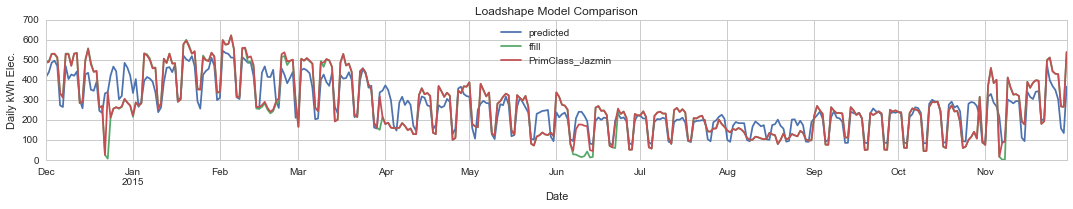

In [1040]:
combined.resample('D').sum().plot(figsize=(15,3))#truncate(after='2014-12-21')
plt.xlabel("Date")
plt.ylabel("Daily kWh Elec.")
plt.title("Loadshape Model Comparison")
plt.tight_layout()

Looks good -- the `ffill` line is simply to show the input to the loadshape program and it looks like the model created a good line (in red) to model the last of the year.

Now let's loop through and do this for all the other misfits and replace their values in the aggregated dataframes

In [1051]:
# for building in changelist:
#     start_time = timeit.default_timer()
#     try:
#         errors, building_data_ffill, building_data, building_data_predicted, residuals = runloadshapemodel_fillna(meta, temp, building)
        
#         temp_gapsfilled = temp_gapsfilled.drop([building],axis=1)
#         temp_gapsfilled = pd.merge(temp_gapsfilled, building_data.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         temp_loadshape_predicted = temp_loadshape_predicted.drop([building],axis=1)
#         temp_loadshape_predicted = pd.merge(temp_loadshape_predicted, building_data_predicted.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         temp_residuals = temp_residuals.drop([building],axis=1)
#         temp_residuals = pd.merge(temp_residuals, residuals.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         features_loadshape_errors = features_loadshape_errors.drop([building],axis=1)
#         features_loadshape_errors = pd.merge(features_loadshape_errors, errors, right_index=True, left_index=True, how='outer')
        
#         print "Calculated: "+building+" in "+str(timeit.default_timer() - start_time)+" seconds"
    
#     except:
#          print "Couldn't model: "+building

Second run -- to fix the truncate error:
```
Calculated: PrimClass_Jenna in 53.3710489273 seconds
Calculated: Office_Georgia in 52.8655359745 seconds
Calculated: UnivDorm_Lysander in 51.8161830902 seconds
Calculated: PrimClass_Jazmin in 51.3481328487 seconds
```

First run:
```
Calculated: UnivClass_Clifford in 51.2051951885 seconds
Calculated: Office_Eileen in 50.7498998642 seconds
Calculated: PrimClass_Jenna in 74.6112937927 seconds
Calculated: Office_Georgia in 73.3232250214 seconds
Calculated: UnivDorm_Payton in 51.7087938786 seconds
Calculated: Office_Alyson in 50.4186689854 seconds
Calculated: UnivDorm_Lysander in 71.5492680073 seconds
Calculated: PrimClass_Jazmin in 75.429872036 seconds
ERROR:loadshape.loadshape: --- R script error: --- 

 --> There were 50 or more warnings (use warnings() to see the first 50)
Calculated: UnivClass_Alfredo in 49.8491010666 seconds
Calculated: Office_Terrell in 49.8591837883 seconds
Calculated: UnivLab_Aurora in 55.5955138206 seconds
Calculated: UnivLab_Alfonso in 51.3142929077 seconds
Calculated: UnivLab_Carole in 49.7617490292 seconds
```

In [1052]:
temp_gapsfilled.describe().T["count"][temp_gapsfilled.describe().T["count"]<8760]

PrimClass_Jenna    8759.0
Name: count, dtype: float64

In [1053]:
temp_gapsfilled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40940 entries, 2010-01-01 08:00:00+00:00 to 2016-01-01 06:00:00+00:00
Columns: 507 entries, Office_Cristina to PrimClass_Jazmin
dtypes: float64(507)
memory usage: 158.7 MB


### but also, we have a lot of leap year buildings with the same issue -- however, much less missing hours. 

In [947]:
#temp_gapsfilled.describe().T["count"][(temp_gapsfilled.describe().T["count"]>8760)&(temp_gapsfilled.describe().T["count"]<8784)]

```
PrimClass_Everett      8779.0
Office_Elizabeth       8773.0
Office_Ellie           8773.0
PrimClass_Elisabeth    8779.0
PrimClass_Esmeralda    8779.0
PrimClass_Eoghan       8779.0
PrimClass_Edwin        8775.0
PrimClass_Eli          8779.0
PrimClass_Ethel        8775.0
PrimClass_Ernesto      8775.0
PrimClass_Emanuela     8777.0
PrimClass_Emilio       8779.0
PrimClass_Eleanor      8779.0
PrimClass_Ezekiel      8779.0
PrimClass_Elliott      8779.0
PrimClass_Ellen        8777.0
PrimClass_Evie         8777.0
PrimClass_Elijah       8779.0
PrimClass_Ezra         8779.0
PrimClass_Edmund       8779.0
PrimClass_Eva          8779.0
Office_Erik            8779.0
PrimClass_Ebony        8777.0
PrimClass_Ethan        8779.0
PrimClass_Elmer        8777.0
PrimClass_Ervin        8779.0
PrimClass_Ernest       8777.0
PrimClass_Emily        8777.0
Office_Evelyn          8773.0
Office_Emer            8779.0
Office_Elena           8779.0
Office_Emerald         8779.0
Office_Ellis           8779.0
Office_Elliot          8779.0
Office_Eddie           8779.0
Name: count, dtype: float64
```

In [929]:
#changelist = list(temp_gapsfilled.describe().T["count"][(temp_gapsfilled.describe().T["count"]>8760)&(temp_gapsfilled.describe().T["count"]<8784)].index)

In [1054]:
#changelist

```
['PrimClass_Everett',
 'Office_Elizabeth',
 'Office_Ellie',
 'PrimClass_Elisabeth',
 'PrimClass_Esmeralda',
 'PrimClass_Eoghan',
 'PrimClass_Edwin',
 'PrimClass_Eli',
 'PrimClass_Ethel',
 'PrimClass_Ernesto',
 'PrimClass_Emanuela',
 'PrimClass_Emilio',
 'PrimClass_Eleanor',
 'PrimClass_Ezekiel',
 'PrimClass_Elliott',
 'PrimClass_Ellen',
 'PrimClass_Evie',
 'PrimClass_Elijah',
 'PrimClass_Ezra',
 'PrimClass_Edmund',
 'PrimClass_Eva',
 'Office_Erik',
 'PrimClass_Ebony',
 'PrimClass_Ethan',
 'PrimClass_Elmer',
 'PrimClass_Ervin',
 'PrimClass_Ernest',
 'PrimClass_Emily',
 'Office_Evelyn',
 'Office_Emer',
 'Office_Elena',
 'Office_Emerald',
 'Office_Ellis',
 'Office_Elliot',
 'Office_Eddie']
 ```

In [933]:
# for building in changelist:
#     start_time = timeit.default_timer()
#     try:
#         errors, building_data_ffill, building_data, building_data_predicted, residuals = runloadshapemodel_fillna(meta, temp, building)
        
#         temp_gapsfilled = temp_gapsfilled.drop([building],axis=1)
#         temp_gapsfilled = pd.merge(temp_gapsfilled, building_data.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         temp_loadshape_predicted = temp_loadshape_predicted.drop([building],axis=1)
#         temp_loadshape_predicted = pd.merge(temp_loadshape_predicted, building_data_predicted.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         temp_residuals = temp_residuals.drop([building],axis=1)
#         temp_residuals = pd.merge(temp_residuals, residuals.tz_convert('utc'), right_index=True, left_index=True, how='outer')

#         features_loadshape_errors = features_loadshape_errors.drop([building],axis=1)
#         features_loadshape_errors = pd.merge(features_loadshape_errors, errors, right_index=True, left_index=True, how='outer')
        
#         print "Calculated: "+building+" in "+str(timeit.default_timer() - start_time)+" seconds"
    
#     except:
#          print "Couldn't model: "+building

```
Calculated: PrimClass_Everett in 51.6812307835 seconds
Calculated: Office_Elizabeth in 52.8812398911 seconds
Calculated: Office_Ellie in 52.0108239651 seconds
Calculated: PrimClass_Elisabeth in 51.8165187836 seconds
Calculated: PrimClass_Esmeralda in 52.4152109623 seconds
Calculated: PrimClass_Eoghan in 52.6025290489 seconds
Calculated: PrimClass_Edwin in 51.9409041405 seconds
Calculated: PrimClass_Eli in 52.4721589088 seconds
Calculated: PrimClass_Ethel in 51.9460749626 seconds
Calculated: PrimClass_Ernesto in 52.0764219761 seconds
Calculated: PrimClass_Emanuela in 52.1782569885 seconds
Calculated: PrimClass_Emilio in 51.8335468769 seconds
Calculated: PrimClass_Eleanor in 52.0018880367 seconds
Calculated: PrimClass_Ezekiel in 51.9689350128 seconds
Calculated: PrimClass_Elliott in 52.5089259148 seconds
Calculated: PrimClass_Ellen in 52.8296308517 seconds
Calculated: PrimClass_Evie in 52.1741809845 seconds
Calculated: PrimClass_Elijah in 52.5221011639 seconds
Calculated: PrimClass_Ezra in 52.8313319683 seconds
Calculated: PrimClass_Edmund in 52.166079998 seconds
Calculated: PrimClass_Eva in 52.4773440361 seconds
Calculated: Office_Erik in 52.4036798477 seconds
Calculated: PrimClass_Ebony in 52.4162490368 seconds
Calculated: PrimClass_Ethan in 51.7964978218 seconds
Calculated: PrimClass_Elmer in 54.2872378826 seconds
Calculated: PrimClass_Ervin in 52.8719718456 seconds
Calculated: PrimClass_Ernest in 53.5486960411 seconds
Calculated: PrimClass_Emily in 53.9929349422 seconds
Calculated: Office_Evelyn in 53.3768079281 seconds
Calculated: Office_Emer in 52.5935239792 seconds
Calculated: Office_Elena in 53.4542658329 seconds
Calculated: Office_Emerald in 53.5287029743 seconds
Calculated: Office_Ellis in 52.9976630211 seconds
Calculated: Office_Elliot in 53.5592501163 seconds
Calculated: Office_Eddie in 52.612005949 seconds
```

In [1055]:
temp_gapsfilled.describe().T["count"][(temp_gapsfilled.describe().T["count"]>8760)&(temp_gapsfilled.describe().T["count"]<8784)]

Series([], Name: count, dtype: float64)

In [1062]:
temp_gapsfilled.describe().T["count"].value_counts()

8760.0    455
8784.0     51
8759.0      1
Name: count, dtype: int64

In [1065]:
list(temp_gapsfilled.columns[temp_gapsfilled.describe().T["count"] == 8759])

['PrimClass_Jenna']

One stubborn building `Jenna` left to fix

In [1445]:
# building = 'PrimClass_Jenna'
# timezone = meta.T[building].timezone
# start = meta.T[building].datastart
# end = meta.T[building].dataend
# building_data_withgaps = pd.DataFrame(temp_gapsfilled[building].tz_convert(timezone).truncate(before=start,after=end))


In [1446]:
#building_data_withgaps.info()

In [1447]:
# building_data_withgaps = building_data_withgaps.ffill()
# building_data_withgaps.info()

In [1448]:
# temp_gapsfilled = temp_gapsfilled.drop([building],axis=1)
# temp_gapsfilled = pd.merge(temp_gapsfilled, building_data_withgaps.tz_convert('utc'), right_index=True, left_index=True, how='outer')

In [1080]:
temp_gapsfilled.describe().T["count"].value_counts()

8760.0    456
8784.0     51
Name: count, dtype: int64

In [1450]:
temp_loadshape_predicted.index.name = 'timestamp'

In [1451]:
temp_gapsfilled.to_csv(os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv"))
temp_loadshape_predicted.to_csv(os.path.join(repos_path,"data/interim/temp_loadshape_predicted.csv"))
features_loadshape_errors.to_csv(os.path.join(repos_path,"data/processed/features_loadshape_errors.csv"))